In [1]:
include("../src/GeneticDemographicModel.jl")
include("../src/DomesticationModel.jl")
include("../src/DemographicParameters.jl")
include("../src/DomesticationParameters.jl")


Main.DomesticationParameters

In [2]:
include("../src/DemographicParameters.jl")

Main.DemographicParameters

In [4]:
Sa = DemographicParameters.Smyth_2016_survival
Fa = DemographicParameters.Smyth_16_F_vec
Wa = DemographicParameters.Smyth_16_WAR.(1:(length(Fa)+1))
R0 = 5.0
Rstar = 100.0
r = 0.0
Sd = (X,b) -> GeneticDemographicModel.BevertonHolt(X,b)
Vr = 0.5
# Scenario 1
targets = (S_F = 0.1, S_E = 0.01, S_J = 1.0, S_C = 1.0, rLRS = 0.9, 
           l50 = 40.0, theta = 10.0)
p_fixed = (a_r = 1.0,decreasing_selection = false,b_sa = 0.0,L_0 = 5.0,
            L_infty = 500,k = 0.05,b_Linfty=10.0,h2_lr=0.75, Vr = 0.5)
pars, natural_selection = DomesticationParameters.solve_parameters(targets,p_fixed)

s1 = 0.25*pars.s
s2 = 0.5*pars.s
s3 = 0.25*pars.s
rFaplastic = 0.9
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
popH = DomesticationModel.init(Sa,Fa,pars)
print("selection strength ", pars.s)


selection strength 0.1353753672231747

In [5]:
using DataFrames, Plots
include("../src/GeneticDemographicModel.jl")
function init_df(t_init, t_hatchery, t_recovery)
    data = DataFrame()
    data.time = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.Recruitment = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.Fitness = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.mean = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.Fitness_H = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.mean_H = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.variance = 1:1.0:(t_init+t_hatchery+t_recovery)
    return data
end 

function statistics!(data,popW,popH,t)
    
    # calcualte statistics 
    Nt = popW.abundanceN[1]
    gradient = popW.gradient1.*popW.gradient2.*popW.gradient3
    Wt = sum(popW.traitN[:,1].*gradient)
    WHt = sum(popH.trait[:,1].*gradient)
    gbart = sum(popW.traitN[:,1].*popW.grid)
    gbarHt = sum(popH.trait[:,1].*popH.grid)
    Vt = sum(popW.traitN[:,1].*(popW.grid.-gbart).^2)
    
    data.time[t] = t
    data.Recruitment[t] = Nt
    data.Fitness[t] = Wt
    data.Fitness_H[t] = WHt
    data.mean[t] = gbart
    data.mean_H[t] = gbarHt
    data.variance[t] = Vt
    
    return Nt, Wt, gbart, Vt
end


function simulation(popW, popH, rH, t_init, t_hatchery, t_recovery)
    
    data = init_df(t_init, t_hatchery, t_recovery)

    for t in 1:t_init
        GeneticDemographicModel.time_step!(popW, popH.trait[:,1], 0.0)
        statistics!(data,popW,popH,t)
    end 
    
    for t in (t_init+1):(t_init+t_hatchery)
        GeneticDemographicModel.time_step!(popW, popH.trait[:,1], rH)
        DomesticationModel.time_step!(popH)
        statistics!(data,popW,popH,t)
    end 
    
    for t in (t_init+t_hatchery+1):(t_init+t_hatchery+t_recovery)
        GeneticDemographicModel.time_step!(popW, popH.trait[:,1], 0.0)
        statistics!(data,popW,popH,t)
    end 
    
    GeneticDemographicModel.rest!(popW)
    DomesticationModel.rest!(popH)
    
    return data
end


function plot_simulation(data,t_init, t_hatchery; label = "")
    Tstart = t_init
    Tend = t_init + t_hatchery
    p1 = Plots.plot(data.time, data.Fitness./data.Fitness[1], color = "black",label=label,ylabel = "Fitness",linewidth=1.5)
    Plots.vspan!(p1,[Tstart,Tend], alpha = 0.5,label="", xlabel="Time (years)",
                xguidefontsize=13,yguidefontsize=13,xtickfontsize=10,ytickfontsize=10)
    p2 = Plots.plot(data.time, data.Recruitment./data.Recruitment[1], color = "black",label="",ylabel = "Recruitment",linewidth=1.5)
    Plots.vspan!(p2,[Tstart,Tend], alpha = 0.5,label="", xlabel="Time (years)",
                xguidefontsize=13,yguidefontsize=13,xtickfontsize=10,ytickfontsize=10)
    p3 = Plots.plot(data.time, data.mean, color = "black",label="",ylabel = "Mean genotype",linewidth=1.5)
    Plots.vspan!(p3,[Tstart,Tend], alpha = 0.5,label="", xlabel="Time (years)",
                xguidefontsize=13,yguidefontsize=13,xtickfontsize=10,ytickfontsize=10)
    p4 = Plots.plot(data.time, data.variance, color = "black",label="",ylabel = "Genotype var.",linewidth=1.5)
    Plots.vspan!(p4,[Tstart,Tend], alpha = 0.5,label="", xlabel="Time (years)",
                xguidefontsize=13,yguidefontsize=13,xtickfontsize=10,ytickfontsize=10)
    
    return p1,p2,p3,p4

end 


function plot_simulation!(plots,data, linestyle;label ="")

    p1,p2,p3,p4 = plots
    p1 = Plots.plot!(p1,data.time, data.Fitness./data.Fitness[1], color = "black", label = label,linestyle = linestyle,linewidth=1.5)
    p2 = Plots.plot!(p2,data.time, data.Recruitment./data.Recruitment[1], color = "black",label="",linestyle = linestyle,linewidth=1.5)
    p3 = Plots.plot!(p3,data.time, data.mean, color = "black",label="",linestyle = linestyle,linewidth=1.5)
    p4 = Plots.plot!(p4,data.time, data.variance, color = "black",label="",linestyle = linestyle,linewidth=1.5)
    
    return p1,p2,p3,p4

end 

plot_simulation! (generic function with 1 method)

In [6]:
t_init = 50
t_hatchery = 100
t_recovery = 500
rH = 25
rFaplastic = 0.8
s1,s2,s3 = (1.0*pars.s,0.0*pars.s,0.0*pars.s)
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
data = simulation(popW, popH, rH , t_init, t_hatchery, t_recovery)
plots = plot_simulation(data, t_init, t_hatchery, label = string(L"s_{v_1} = 1", " before"))
s1,s2,s3 = (0.0*pars.s,1.0*pars.s,0.0*pars.s)
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
data = simulation(popW, popH, rH, t_init, t_hatchery, t_recovery)
p1,p2,p3,p4=plot_simulation!(plots, data, :dash, label = string(L"s_{v_2} = 1", " after"))
s1,s2,s3 = (0.0*pars.s,0.0*pars.s,1.0*pars.s)
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
data = simulation(popW, popH, rH, t_init, t_hatchery, t_recovery)
p1,p2,p3,p4=plot_simulation!(plots, data, :dashdot, label = string(L"s_{f} = 1", " fecundity"))
plot(p1,p2,p3,p4)

LoadError: LoadError: UndefVarError: @L_str not defined
in expression starting at /Users/johnbuckner/github/Nechako  Sturgeon Hatchery Model/Analysis/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sZmlsZQ==.jl:9

# $R_0$

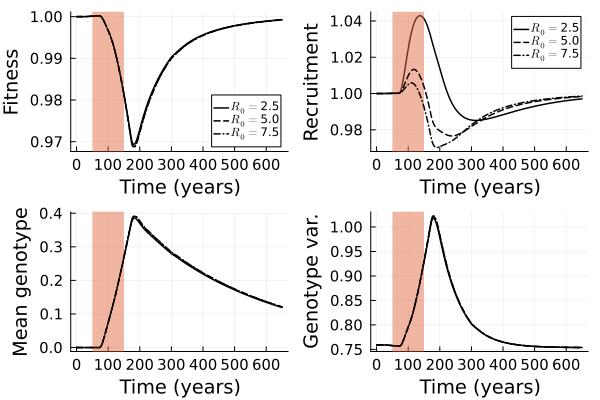

In [32]:
using LaTeXStrings
t_init = 50
t_hatchery = 100
t_recovery = 500
rH = 25
rFaplastic = 0.8
s1,s2,s3 = (0.0*pars.s,1.0*pars.s,0.0*pars.s)
R0_ = 0.5*R0
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0_,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
data = simulation(popW, popH, rH , t_init, t_hatchery, t_recovery)
plots = plot_simulation(data, t_init, t_hatchery, label = string(L"$R_0 = $", 0.5*R0))
R0_ = R0
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0_,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
data = simulation(popW, popH, rH, t_init, t_hatchery, t_recovery)
p1,p2,p3,p4=plot_simulation!(plots, data, :dash, label = string(L"$R_0 = $", R0))

R0_ = 1.5*R0
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0_,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
data = simulation(popW, popH, rH, t_init, t_hatchery, t_recovery)
p1,p2,p3,p4=plot_simulation!(plots, data, :dashdot, label = string(L"$R_0 = $", 1.5*R0))
plot(p1,p2,p3,p4)


# Environemtnal effect of the hatchery on fitness

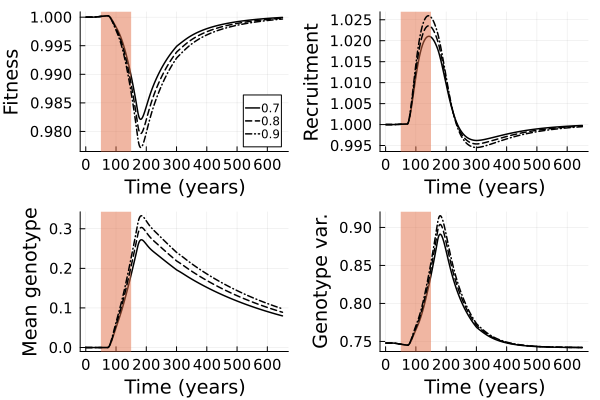

In [21]:
s1,s2,s3 = (0.5*pars.s,0.5*pars.s,0.0*pars.s)
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,0.7)
data = simulation(popW, popH, rH , t_init, t_hatchery, t_recovery)
plots = plot_simulation(data, t_init, t_hatchery, label = "0.7")
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,0.8)
data = simulation(popW, popH, rH, t_init, t_hatchery, t_recovery)
p1,p2,p3,p4=plot_simulation!(plots, data, :dash, label = "0.8")
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,0.9)
data = simulation(popW, popH, rH, t_init, t_hatchery, t_recovery)
p1,p2,p3,p4=plot_simulation!(plots, data, :dashdot, label = "0.9")
plot(p1,p2,p3,p4)


# Fitness differnces 

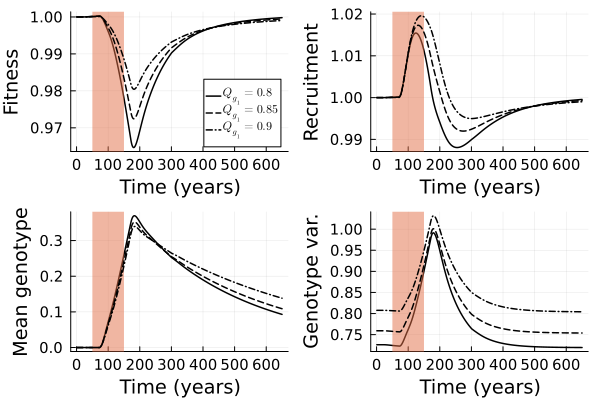

In [38]:
using LaTeXStrings
targets = (S_F = 0.1, S_E = 0.0025, S_J = 1.0, S_C = 1.0, rLRS = 0.8, l50 = 40.0, theta = 10.0)
pars, natural_selection = DomesticationParameters.solve_parameters(targets,p_fixed)
s1,s2,s3 = (0.5*pars.s,0.5*pars.s,0.0*pars.s)
rFaplastic = 0.75
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
popH = DomesticationModel.init(Sa,Fa,pars)
data = simulation(popW, popH, rH , t_init, t_hatchery, t_recovery)
plots = plot_simulation(data, t_init, t_hatchery, label = L"Q_{g_1} = 0.8")

targets = (S_F = 0.1, S_E = 0.005, S_J = 1.0, S_C = 1.0, rLRS = 0.85, l50 = 40.0, theta = 10.0)
pars, natural_selection = DomesticationParameters.solve_parameters(targets,p_fixed)
s1,s2,s3 = (0.5*pars.s,0.5*pars.s,0.0*pars.s)
rFaplastic = 0.706
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
popH = DomesticationModel.init(Sa,Fa,pars)
data = simulation(popW, popH, rH, t_init, t_hatchery, t_recovery)
p1,p2,p3,p4=plot_simulation!(plots, data, :dash, label = L"Q_{g_1} = 0.85")

targets = (S_F = 0.1, S_E = 0.01, S_J = 1.0, S_C = 1.0, rLRS = 0.9, l50 = 40.0, theta = 10.0)
pars, natural_selection = DomesticationParameters.solve_parameters(targets,p_fixed)
s1,s2,s3 = (0.5*pars.s,0.5*pars.s,0.0*pars.s)
rFaplastic = 0.6666
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
popH = DomesticationModel.init(Sa,Fa,pars)
data = simulation(popW, popH, rH, t_init, t_hatchery, t_recovery)
p1,p2,p3,p4=plot_simulation!(plots, data, :dashdot, label = L"Q_{g_1} = 0.9")
plot(p1,p2,p3,p4)

# Selection strength 

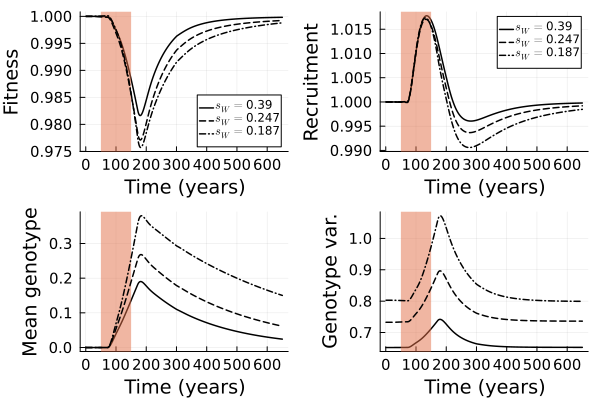

In [30]:
rFaplastic = 0.706
s1,s2,s3 = (0.5*pars.s,0.5*pars.s,0.0*pars.s)
targets = (S_F = 0.1, S_E = 0.025, S_J = 1.0, S_C = 1.0, rLRS = 0.85, l50 = 40.0, theta = 10.0)
pars1, natural_selection = DomesticationParameters.solve_parameters(targets,p_fixed)
pars = pars1
s1,s2,s3 = (0.25*pars.s,0.5*pars.s,0.25*pars.s)
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
popH = DomesticationModel.init(Sa,Fa,pars)
data = simulation(popW, popH, rH , t_init, t_hatchery, t_recovery)
plots = plot_simulation(data, t_init, t_hatchery, label = string(L"s_W = ", round(pars.s,digits = 3)))


targets = (S_F = 0.1, S_E = 0.01, S_J = 1.0, S_C = 1.0, rLRS = 0.85, l50 = 40.0, theta = 10.0)
pars2, natural_selection = DomesticationParameters.solve_parameters(targets,p_fixed)
pars = pars2

s1,s2,s3 = (0.25*pars.s,0.5*pars.s,0.25*pars.s)
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
popH = DomesticationModel.init(Sa,Fa,pars)
data = simulation(popW, popH, rH, t_init, t_hatchery, t_recovery)
p1,p2,p3,p4=plot_simulation!(plots, data, :dash, label = string(L"s_W = ", round(pars.s,digits = 3)))

targets = (S_F = 0.1, S_E = 0.005, S_J = 1.0, S_C = 1.0, rLRS = 0.85, l50 = 40.0, theta = 10.0)
pars3, natural_selection = DomesticationParameters.solve_parameters(targets,p_fixed)
pars = pars3
s1,s2,s3 = (0.25*pars.s,0.5*pars.s,0.0*pars.s)
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
popH = DomesticationModel.init(Sa,Fa,pars)
data = simulation(popW, popH, rH, t_init, t_hatchery, t_recovery)
p1,p2,p3,p4=plot_simulation!(plots, data, :dashdot, label = string(L"s_W = ", round(pars.s,digits = 3)))
plot(p1,p2,p3,p4)

